In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, shutil

orig_dir = 'chest_xray/train'
orig_dir2 = 'chest_xray/test'

Remove existing directories and make new directories.

In [3]:
%%time
train_dir = './train'
valid_dir = './validation'
test_dir = './test'

for d in [train_dir, valid_dir, test_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.mkdir(d)
    os.mkdir(os.path.join(d,'NORMAL'))
    os.mkdir(os.path.join(d,'PNEUMONIA'))
print(os.listdir(train_dir))

['NORMAL', 'PNEUMONIA']
Wall time: 1.61 s


List all normal and pneumonia image paths in original train and test data.

In [4]:
%%time
normal_images = [os.path.join(orig_dir, 'NORMAL', x) for x in os.listdir(os.path.join(orig_dir, 'NORMAL')) if x.endswith('.jpeg')]
normal_images += [os.path.join(orig_dir2, 'NORMAL', x) for x in os.listdir(os.path.join(orig_dir2, 'NORMAL')) if x.endswith('.jpeg')]
pneumonia_images = [os.path.join(orig_dir, 'PNEUMONIA', x) for x in os.listdir(os.path.join(orig_dir, 'PNEUMONIA')) if x.endswith('.jpeg')]
pneumonia_images += [os.path.join(orig_dir2, 'PNEUMONIA', x) for x in os.listdir(os.path.join(orig_dir2, 'PNEUMONIA')) if x.endswith('.jpeg')]


print(len(normal_images))
print(len(pneumonia_images))

1583
4273
Wall time: 38.9 ms


In [5]:
print(normal_images[0])
print(normal_images[0].split('\\')[-1])

chest_xray/train\NORMAL\IM-0115-0001.jpeg
IM-0115-0001.jpeg


Randomize the order of the images.

In [6]:
%%time
random.shuffle(normal_images)
random.shuffle(pneumonia_images)

Wall time: 0 ns


Copy the images from original directories to new ones and split them into train, validation and test folders. (0.6 : 0.2 : 0.2)

In [7]:
%%time
split = int(0.2 * len(normal_images))
for file in normal_images[:split]:
    shutil.copyfile(file, os.path.join(test_dir, 'NORMAL', file.split('\\')[-1]))

for file in normal_images[split:split * 2]:
    shutil.copyfile(file, os.path.join(valid_dir, 'NORMAL', file.split('\\')[-1]))
    
for file in normal_images[split * 2:]:
    shutil.copyfile(file, os.path.join(train_dir, 'NORMAL', file.split('\\')[-1]))

Wall time: 3.47 s


In [8]:
%%time
split = int(0.2 * len(pneumonia_images))
for file in pneumonia_images[:split]:
    shutil.copyfile(file, os.path.join(test_dir, 'PNEUMONIA', file.split('\\')[-1]))

for file in pneumonia_images[split:split * 2]:
    shutil.copyfile(file, os.path.join(valid_dir, 'PNEUMONIA', file.split('\\')[-1]))
    
for file in pneumonia_images[split * 2:]:
    shutil.copyfile(file, os.path.join(train_dir, 'PNEUMONIA', file.split('\\')[-1]))

Wall time: 5.2 s


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

scale = 1./255
datagen = ImageDataGenerator(rescale=scale)

In [10]:
target_size = (150,150)
batch_size = 16
class_mode = 'binary'

train_generator = datagen.flow_from_directory(
    train_dir, target_size,
    batch_size=batch_size,
    class_mode=class_mode)

dev_generator = datagen.flow_from_directory(
    valid_dir, target_size,
    batch_size=batch_size,
    class_mode=class_mode)

test_generator = datagen.flow_from_directory(
    test_dir, target_size,
    batch_size=batch_size,
    class_mode=class_mode)

Found 3516 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


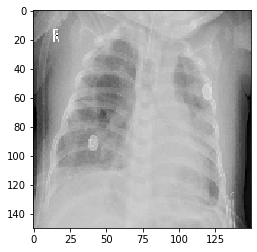

(150, 150, 3)

In [11]:
data_batch = train_generator[0][0]
imshow(data_batch[0])
show()
data_batch[0].shape

In [12]:
#Build and compile the model

from tensorflow.keras import models, layers

network = models.Sequential()
network.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = "same",input_shape=data_batch[0].shape))
network.add(layers.MaxPooling2D((2,2)))
network.add(layers.Conv2D(32, (3,3), activation = 'relu'))
network.add(layers.MaxPooling2D((2,2)))
network.add(layers.Conv2D(32, (3,3), padding = "same", activation = 'relu'))
network.add(layers.MaxPooling2D((2,2)))
network.add(layers.Flatten())
network.add(layers.Dense(1, activation = 'sigmoid'))

network.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0

In [13]:
from tensorflow.keras.metrics import SensitivityAtSpecificity

network.compile(loss='binary_crossentropy', metrics=[SensitivityAtSpecificity(0.9)])

In [ ]:
%%time
history = network.fit_generator(train_generator,
                                workers=4,
                                steps_per_epoch=int(train_generator.samples / batch_size)-1,
                                verbose=1,
                                epochs=1,
                                validation_data=dev_generator,
                                validation_steps=dev_generator.samples)

216/218 [============================>.] - ETA: 1s - loss: 0.3438 - sensitivity_at_specificity: 0.6973

In [ ]:
history.history.keys()

In [ ]:
sas = history.history['sensitivity_at_specificity']
val_sas = history.history['val_sensitivity_at_specificity']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(sas))

In [ ]:
plot(epochs,sas,'bo-',label='Training sas')
plot(epochs,val_sas,'r*-',label='Validation sas')
title('Training and validation sas')
grid()
legend()

figure()
plot(epochs,loss,'bo-',label='Training loss')
plot(epochs,val_loss,'r*-',label='Validation loss')
title('Training and validation loss')
grid()
legend()

show()